In [1]:
# This notebook is derived from Qiskit and includes modifications by qBraid.
#
# (C) Copyright IBM 2020.
# (C) Copyright qBraid 2023.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# qBraid-SDK Qiskit on AWS Device Demo: Bernstein-Vazirani Algorithm

In [2]:
import qbraid

qbraid.__version__

'0.7.0.dev'

## Creating the Circuit

In [3]:
from qiskit import QuantumCircuit

The code for this circuit was taken from IBMs Bernstein-Vazirani algorithm tutorial. Check out their [tutorial](https://www.youtube.com/watch?v=sqJIpHYl7oo) for a more in depth explanation. Classically, it takes $n$ queries to decipher a secret string of length $n$ – the Bernstein-Vazirani algorithm allows us to develop an oracle in a quantum circuit that is able to guess the string with just one query!

In [4]:
s = "110101"  # the number we hope to guess
n = len(s)

qiskit_circuit = QuantumCircuit(n + 1, n)

qiskit_circuit.x(n)
qiskit_circuit.barrier()
qiskit_circuit.h(range(n + 1))
qiskit_circuit.barrier()

for ii, yesno in enumerate(reversed(s)):
    if yesno == "1":
        qiskit_circuit.cx(ii, n)

qiskit_circuit.barrier()
qiskit_circuit.h(range(n + 1))
qiskit_circuit.barrier()
qiskit_circuit.measure(range(n), range(n))

In [5]:
from qbraid.visualization import circuit_drawer

circuit_drawer(qiskit_circuit, "mpl")  # Visualizing the circuit

░ ┌───┐ ░                      ░ ┌───┐ ░ ┌─┐               
q_0: ──────░─┤ H ├─░───■──────────────────░─┤ H ├─░─┤M├───────────────
           ░ ├───┤ ░   │                  ░ ├───┤ ░ └╥┘┌─┐            
q_1: ──────░─┤ H ├─░───┼──────────────────░─┤ H ├─░──╫─┤M├────────────
           ░ ├───┤ ░   │                  ░ ├───┤ ░  ║ └╥┘┌─┐         
q_2: ──────░─┤ H ├─░───┼────■─────────────░─┤ H ├─░──╫──╫─┤M├─────────
           ░ ├───┤ ░   │    │             ░ ├───┤ ░  ║  ║ └╥┘┌─┐      
q_3: ──────░─┤ H ├─░───┼────┼─────────────░─┤ H ├─░──╫──╫──╫─┤M├──────
           ░ ├───┤ ░   │    │             ░ ├───┤ ░  ║  ║  ║ └╥┘┌─┐   
q_4: ──────░─┤ H ├─░───┼────┼────■────────░─┤ H ├─░──╫──╫──╫──╫─┤M├───
           ░ ├───┤ ░   │    │    │        ░ ├───┤ ░  ║  ║  ║  ║ └╥┘┌─┐
q_5: ──────░─┤ H ├─░───┼────┼────┼────■───░─┤ H ├─░──╫──╫──╫──╫──╫─┤M├
     ┌───┐ ░ ├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ ├───┤ ░  ║  ║  ║  ║  ║ └╥┘
q_6: ┤ X ├─░─┤ H ├─░─┤ X ├┤ X ├┤ X ├┤ X ├─░─┤ H ├─░──╫──╫──╫──╫──╫──╫─
     └───┘ ░ └───┘ ░ └───┘└───┘└───┘└───┘ ░ └───┘ ░  ║  ║  ║  ║  ║  ║ 
c: 6/════════════════════════════════════════════════╩══╩══╩══╩══╩══╩═
                                                     0  1  2  3  4  5

## Running on an AWS Device via qBraid

Let's check which devices (specifically AWS ones) are online, and also find their device IDs:

In [6]:
from qbraid.runtime.braket import BraketProvider

In [7]:
provider = BraketProvider()
provider.get_devices()

[<qbraid.runtime.braket.device.BraketDevice('arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1')>,
 <qbraid.runtime.braket.device.BraketDevice('arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2')>,
 <qbraid.runtime.braket.device.BraketDevice('arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3')>,
 <qbraid.runtime.braket.device.BraketDevice('arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1')>,
 <qbraid.runtime.braket.device.BraketDevice('arn:aws:braket:us-east-1::device/qpu/ionq/Harmony')>,
 <qbraid.runtime.braket.device.BraketDevice('arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy')>,
 <qbraid.runtime.braket.device.BraketDevice('arn:aws:braket:::device/quantum-simulator/amazon/sv1')>,
 <qbraid.runtime.braket.device.BraketDevice('arn:aws:braket:::device/quantum-simulator/amazon/tn1')>,
 <qbraid.runtime.braket.device.BraketDevice('arn:aws:braket:::device/quantum-simulator/amazon/dm1')>]

In this tutorial we'll use Amazon's SV1 computer, since we see that it's online. Now we can use the BraketProvider run a job on an Amazon device. The device wrapper adds a layer of abstraction, allowing us to run a qiskit circuit on an AWS quantum computer. Note that there's no need for any sort of circuit wrapper here – we can plug the qiskit circuit directly into the wrapped device!

In [8]:
aws_device_id = "arn:aws:braket:::device/quantum-simulator/amazon/sv1" 
device = provider.get_device(aws_device_id)

In [9]:
braket_job = device.run(qiskit_circuit, shots=100)
braket_job.status()

/home/jovyan/.qbraid/environments/qbraid_k2j4i1/pyenv/lib/python3.9/site-packages/qiskit_braket_provider/providers/adapter.py:442: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(


<JobStatus.COMPLETED: 'job has successfully run'>

In [10]:
result = braket_job.result()
counts = result.measurement_counts()
print(counts)

{'1110101': 100}


In [11]:
from qbraid.visualization import plot_histogram

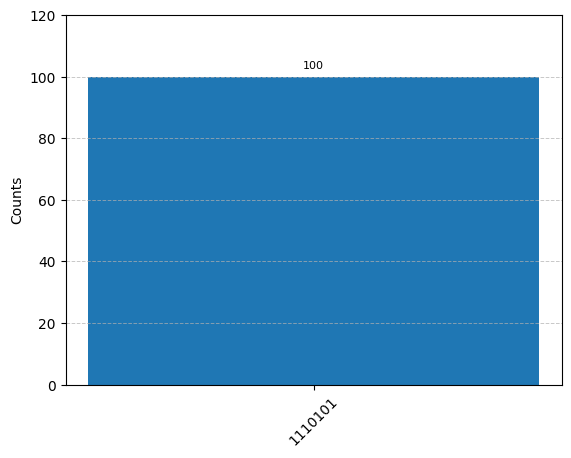

In [12]:
plot_histogram(counts)

We have guessed the number correctly! Note the bar graph where only one number was guessed in all 100 shots